In [15]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
file_list = [
    #"results/VI_gaussian_iwae/savefile_epoch199.npz",
    #"results/VI_laplacian_iwae/savefile_epoch199.npz",
    "results/VI_laplacian_fixeddict/savefile_epoch399.npz",
    "results/VI_gaussian_fixeddict/savefile_epoch399.npz",
    #"results/VI_concreteslab_iwae_temp5e-3/savefile_epoch199.npz",
    #"results/VI_concreteslab_threshold/savefile_epoch199.npz",
    "results/VI_laplacian-vampprior_iwae2/savefile_epoch399.npz",
    "results/VI_gaussian-vampprior_iwae2/savefile_epoch399.npz"
]

file_labels = [
    #"Gaussian",
    #"Laplacian",
    "Thresholded Laplacian",
    "Thresholded Gaussian",
    #"Spike-Slab",
    #"Concrete-Slab",
    #"Thresholded Concrete-Slab",
    "Threshold Laplacian VampPrior",
    "Threshold Gaussian VampPrior"
]

val_true_recon = {}
val_recon = {} 
val_l1 = {} 
val_true_l1 = {}
val_kl_loss = {} 
coeff_est = {} 
coeff_true = {}
num_true_supp = {}
num_redundant_supp = {}
est_active_coeff = {}
true_active_coeff = {}
classification_acc = {}

In [17]:
for idx, file in enumerate(file_list):
    data_file = np.load(file)
    val_true_recon[file_labels[idx]] = data_file['val_true_recon']
    val_recon[file_labels[idx]] = data_file['val_recon']
    val_l1[file_labels[idx]] = data_file['val_l1']
    val_true_l1[file_labels[idx]] = data_file['val_true_l1']
    val_kl_loss[file_labels[idx]] = data_file['val_kl_loss']
    coeff_est[file_labels[idx]] = data_file['coeff_est']
    coeff_true[file_labels[idx]] = data_file['coeff_true']
    num_true_supp[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))
    num_redundant_supp[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))
    true_active_coeff[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))
    est_active_coeff[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))   
    classification_acc[file_labels[idx]] = np.zeros(len(coeff_true[file_labels[idx]]))    
 
    for i in range(len(coeff_true[file_labels[idx]])):
        for j in range(coeff_true[file_labels[idx]].shape[1]):
            true_sup = np.nonzero(coeff_true[file_labels[idx]][i, j])[0]
            est_sup = np.nonzero(coeff_est[file_labels[idx]][i, j])[0]
            missed_support = np.setdiff1d(true_sup, est_sup)
            excess_support = np.setdiff1d(est_sup, true_sup)
            true_active_coeff[file_labels[idx]][i] += len(true_sup) / coeff_true[file_labels[idx]].shape[2]
            est_active_coeff[file_labels[idx]][i] += len(est_sup) / coeff_est[file_labels[idx]].shape[2]
            num_true_supp[file_labels[idx]][i] += (1 - (len(missed_support) / coeff_est[file_labels[idx]].shape[2]))
            num_redundant_supp[file_labels[idx]][i] += (len(excess_support) / coeff_est[file_labels[idx]].shape[2])
            classification_acc[file_labels[idx]][i] += (coeff_est[file_labels[idx]].shape[2] - len(missed_support) - len(excess_support)) 
        true_active_coeff[file_labels[idx]][i] /= coeff_true[file_labels[idx]].shape[1]
        est_active_coeff[file_labels[idx]][i] /= coeff_est[file_labels[idx]].shape[1]
        num_true_supp[file_labels[idx]][i] /= coeff_true[file_labels[idx]].shape[1]
        num_redundant_supp[file_labels[idx]][i] /= coeff_est[file_labels[idx]].shape[1]
        classification_acc[file_labels[idx]][i] /= (coeff_est[file_labels[idx]].shape[1] * coeff_est[file_labels[idx]].shape[2])

/tmp/ipykernel_3205794/290091441.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, 0].semilogy(np.linalg.norm(coeff_est[label] - coeff_true[label], axis=-1).mean(axis=1), linewidth=4, label=label)


Text(0, 0.5, 'Log Mean Value')

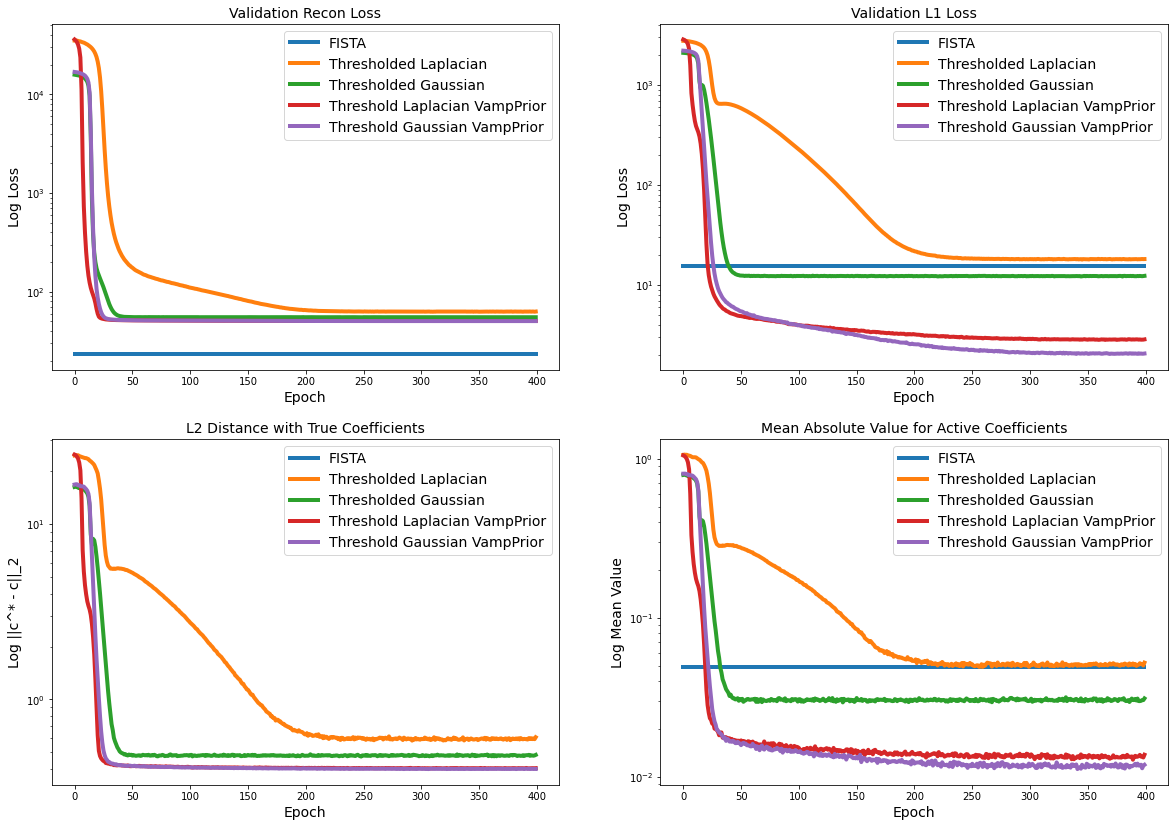

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

for idx, label in enumerate(file_labels):
    if idx == 0:
        ax[0, 0].semilogy(val_true_recon[label], linewidth=4, label="FISTA")
        ax[0, 1].semilogy(val_true_l1[label], linewidth=4, label="FISTA")
        ax[1, 0].plot(np.zeros(len(coeff_est[label])), linewidth=4, label="FISTA")
        ax[1, 1].semilogy(np.abs(coeff_true[label]).sum(axis=(1, 2)) / np.count_nonzero(coeff_true[label], axis=(1, 2)), linewidth=4, label="FISTA")

    ax[0, 0].semilogy(val_recon[label], linewidth=4, label=label)
    ax[0, 1].semilogy(val_l1[label], linewidth=4, label=label)
    ax[1, 0].semilogy(np.linalg.norm(coeff_est[label] - coeff_true[label], axis=-1).mean(axis=1), linewidth=4, label=label)
    ax[1, 1].semilogy(np.abs(coeff_est[label]).sum(axis=(1, 2)) / np.count_nonzero(coeff_est[label], axis=(1, 2)), linewidth=4, label=label)

ax[0, 0].legend(fontsize=14)
ax[0, 0].set_title("Validation Recon Loss", fontsize=14)
ax[0, 0].set_xlabel("Epoch", fontsize=14)
ax[0, 0].set_ylabel("Log Loss", fontsize=14)

ax[0, 1].legend(fontsize=14)
ax[0, 1].set_title("Validation L1 Loss", fontsize=14)
ax[0, 1].set_xlabel("Epoch", fontsize=14)
ax[0, 1].set_ylabel("Log Loss", fontsize=14)

ax[1, 0].legend(fontsize=14)
ax[1, 0].set_title("L2 Distance with True Coefficients", fontsize=14)
ax[1, 0].set_xlabel("Epoch", fontsize=14)
ax[1, 0].set_ylabel("Log ||c^* - c||_2", fontsize=14)

ax[1, 1].legend(fontsize=14)
ax[1, 1].set_title("Mean Absolute Value for Active Coefficients", fontsize=14)
ax[1, 1].set_xlabel("Epoch", fontsize=14)
ax[1, 1].set_ylabel("Log Mean Value", fontsize=14)

(-0.1, 1.1)

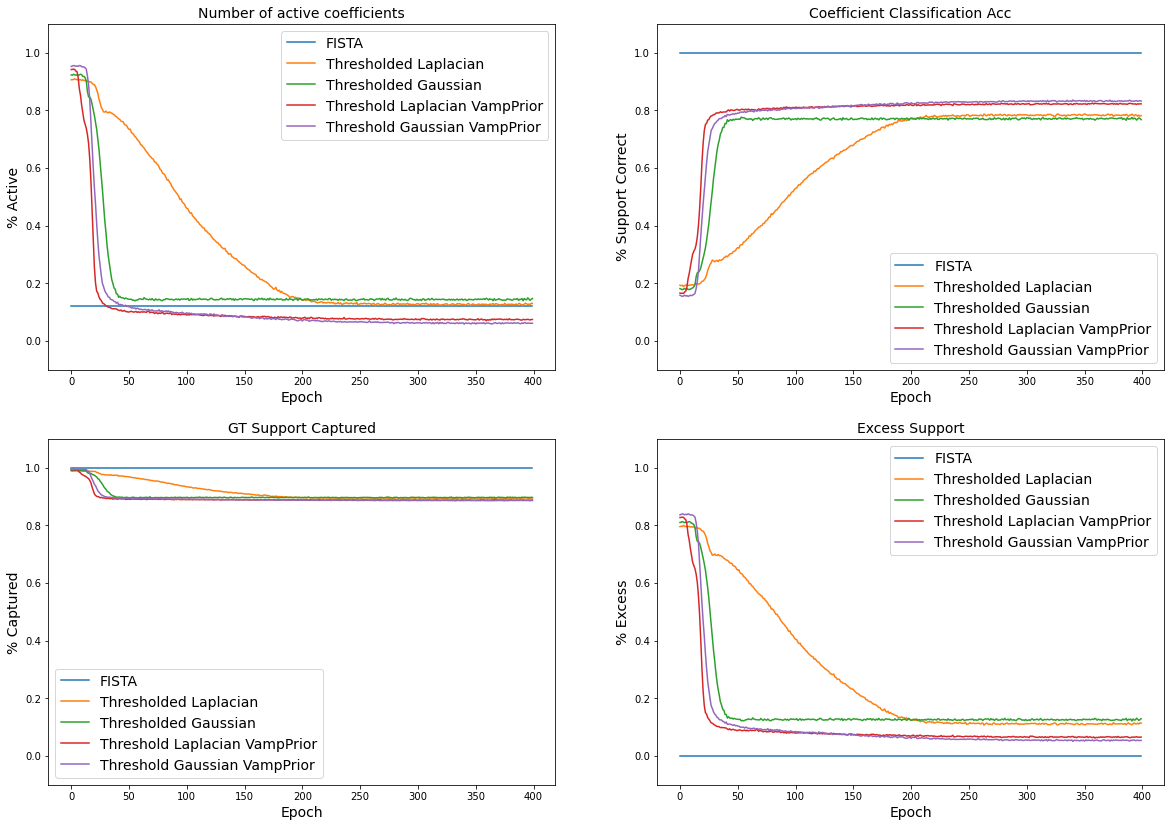

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

for idx, label in enumerate(file_labels):
    if idx == 0:
        ax[0, 0].plot(true_active_coeff[label], linewidth=4, label="FISTA")
        ax[0, 1].plot(np.ones(len(classification_acc[label])), linewidth=4, label="FISTA")
        ax[1, 0].plot(np.ones(len(num_true_supp[label])), linewidth=4, label="FISTA")
        ax[1, 1].plot(np.zeros(len(num_true_supp[label])), linewidth=4, label="FISTA")        
    ax[0, 0].plot(est_active_coeff[label], linewidth=4, label=label)
    ax[0, 1].plot(classification_acc[label], linewidth=4, label=label)
    ax[1, 0].plot(num_true_supp[label], linewidth=4, label=label)
    ax[1, 1].plot(num_redundant_supp[label], linewidth=4, label=label)

ax[0, 0].legend(fontsize=14)
ax[0, 0].set_title("Number of active coefficients", fontsize=14)
ax[0, 0].set_xlabel("Epoch", fontsize=14)
ax[0, 0].set_ylabel("% Active", fontsize=14)
ax[0, 0].set_ylim([-.1, 1.1])

ax[0, 1].legend(fontsize=14)
ax[0, 1].set_title("Coefficient Classification Acc", fontsize=14)
ax[0, 1].set_xlabel("Epoch", fontsize=14)
ax[0, 1].set_ylabel("% Support Correct", fontsize=14)
ax[0, 1].set_ylim([-.1, 1.1])

ax[1, 0].legend(fontsize=14)
ax[1, 0].set_title("GT Support Captured", fontsize=14)
ax[1, 0].set_xlabel("Epoch", fontsize=14)
ax[1, 0].set_ylabel("% Captured", fontsize=14)
ax[1, 0].set_ylim([-.1, 1.1])

ax[1, 1].legend(fontsize=14)
ax[1, 1].set_title("Excess Support", fontsize=14)
ax[1, 1].set_xlabel("Epoch", fontsize=14)
ax[1, 1].set_ylabel("% Excess", fontsize=14)
ax[1, 1].set_ylim([-.1, 1.1])
